# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def get_kernelized_ls_ds(N=25, s=.2, lim=(-5, 5)):
    np.random.seed(98)
    f = lambda x: np.sin(0.9*x).flatten()
    X = np.random.uniform(lim[0], lim[1], size=N)
    y = f(X) + s*np.random.randn(N)
    return (X,y,f)

def get_dna_sequences():
    X_train = ["TCCGTTACCGTGTAACCGACGCCAAGACCGAG", "GCTTGTAATCTGTTTTGACGCCCTCGTCCATGATG", "AGTCAAGCTTTGGTTATTTGTGGTGTTCAATA",\
         "ACCTGAATCTAGTAACCGACGGCGTGTACGATA", "CTTAAAACCTGTTATTAATGCGGTAAAAT", "CCTGCATGCGTGGAAGTGACGCCTATCCAT",\
         "TGTTATACCTTTGGATCATTATTGAGTGAAA", "CTTCAACGCCTATTATTTTGGGTGTGAAAT", "ACCGTAAGTGTTACAGACCGTAAGTACCGTTG",\
         "CGTTCAACGCCTAGGTGTATTGGGTGTCTG"]
    y_train = [1, 1, -1, 1, -1, 1, -1, -1, 1, -1]

    X_test = ["CTTTCAAGGCCCTAATTATCATTGGGTTGAAT", "CGTACCACCCTTCGTTGATGTTTCCGGGAAT", "TCGTACTGCGAACTGAGCCTAGTGACCGACG"]
    y_test = [-1, 1, 1]

    return (X_train, y_train, X_test, y_test)

# Kernel Methods

## Kernelized Least Squares
In this task, we will implement a least squares which utilizes kernels. We will use the *dual representation* to make predictions.
Use the following data:

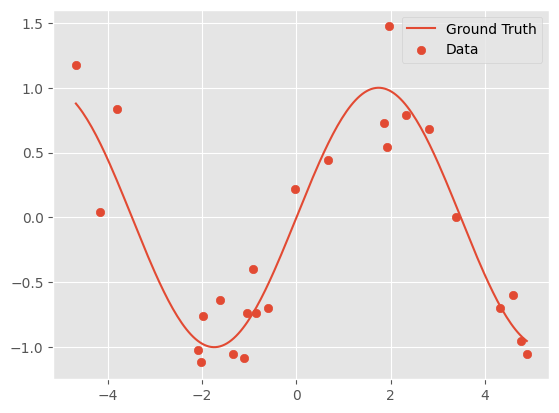

In [2]:
X, y, f = get_kernelized_ls_ds()

axis = np.linspace(min(X), max(X), 201)
plt.plot(axis, f(axis), label='Ground Truth')
plt.scatter(X, y, label='Data')
plt.legend()
plt.show()

> Implement the Gaussian kernel (also called radial basis function kernel):
> $$k\left(\mathbf{x}, \mathbf{x}^{\prime}\right)=\exp \left(-\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|^{2} / 2 \sigma^{2}\right)$$

In [3]:
class GaussianKernel:
    def __init__(self, h):
        assert h > 0, 'The bandwidth needs to be greater than 0.'
        self.h = h

    def __call__(self, u, v):
        u, v = np.array(u), np.array(v)
        w = u - v
        return np.exp( -np.sum((u-v)**2) / (2*self.h**2) )

kernel = GaussianKernel(h=1)
kernel([1, 2], [2, 1]) # returns 0.36787944117144233

0.36787944117144233

> Implement the following methods for the class `KernelizedRegression`:
> - `init`: Init the Regression model and set the kernel function.
> - `fit`: Calculate the gram martix $\mathbf{K}$ and $\mathbf{a}$ according to $$K_{n m}=k\left(\mathbf{x}_{n}, \mathbf{x}_{m}\right) \quad \quad \mathbf{a}=\left(\mathbf{K}+\lambda \mathbf{I}_{N}\right)^{-1} \mathbf{t}$$
> - `predict`: Exploit $\mathbf{a}$ to make predictions according to $$y(\mathbf{x}) = \mathbf{k}(\mathbf{x})^{\mathrm{T}} \underbrace{\left(\mathbf{K}+\lambda \mathbf{I}_{N}\right)^{-1} \mathbf{t}}_{\mathbf{a}}$$

In [4]:
class KernelizedRegression:
    def __init__(self, kernel_func):
        self.kernel_func = kernel_func

    def fit(self, X, y, lmb=0):
        self.X, self.y = X, y
        self.K = np.array([[self.kernel_func(a, b) for a in self.X] for b in self.X])
        self.a = np.linalg.pinv(self.K + lmb*np.eye(len(self.K))) @ y

    def predict(self, x):
        k = np.array([self.kernel_func(x, x_n) for x_n in self.X])
        y_pred = k @ self.a
        return y_pred

clf = KernelizedRegression(GaussianKernel(h=1))
clf.fit(X, y)
clf.predict(0.5)

-23.76603632802149

>Use the implemented model to make predictions for our regression task defined above. Try different values for $\lambda$.

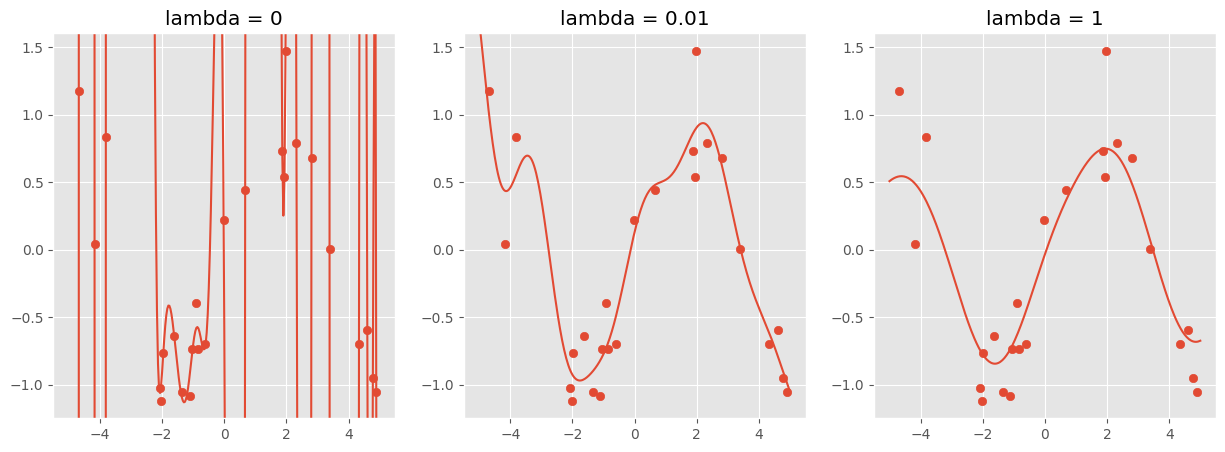

In [5]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
lmb=0
axis = np.linspace(-5, 5, 301)
clf = KernelizedRegression(GaussianKernel(h=1))
clf.fit(X, y, lmb=lmb)
axis_pred = [clf.predict(x) for x in axis]

plt.title('lambda = {}'.format(lmb))
plt.scatter(X, y)
plt.ylim(plt.ylim())
plt.plot(axis, axis_pred)

plt.subplot(132)
lmb=0.01
clf = KernelizedRegression(GaussianKernel(h=1))
clf.fit(X, y, lmb=lmb)
axis_pred = [clf.predict(x) for x in axis]

plt.title('lambda = {}'.format(lmb))
plt.scatter(X, y)
plt.ylim(plt.ylim())
plt.plot(axis, axis_pred)

plt.subplot(133)
lmb=1
clf = KernelizedRegression(GaussianKernel(h=1))
clf.fit(X, y, lmb=lmb)
axis_pred = [clf.predict(x) for x in axis]

plt.title('lambda = {}'.format(lmb))
plt.scatter(X, y)
plt.ylim(plt.ylim())
plt.plot(axis, axis_pred)

plt.show()

> Find the best parameters for $\lambda$ and the bandwidth parameter of the gaussian kernel by using grid search and cross validation. For that, use  `KFold` from `sklearn.model_selection` and plot the *best* model.

Best Bandwidth: 1.6673333333333331; Best lambda 0.5555555555555556


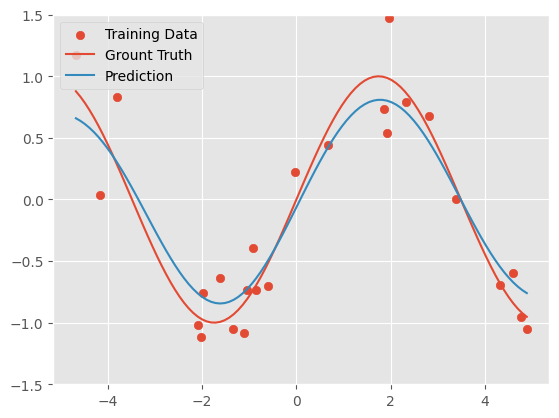

In [6]:
from sklearn.model_selection import KFold

# Define the performance of a model with the rmse loss
def rmse_func(y_pred, y):
    return np.sqrt(np.sum((y_pred - y)**2) / len(y_pred))

# Define the hyperparam range to evaluate
bandwidth_values = np.linspace(1e-3, 5, 10)
lambda_values = np.linspace(0, 5, 10)

# Define the KFold object
n_splits = 5
kf = KFold(n_splits=n_splits)

# Variable to store scores
scores = np.zeros((n_splits, len(bandwidth_values), len(lambda_values)))

for i_bandwidth, bandwidth in enumerate(bandwidth_values):
    for i_lmb, lmb in enumerate(lambda_values):
        for i_split, (train_idx, test_idx) in enumerate(kf.split(X)):
            # Define train test split from cross validation
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]

            # Define the model
            kernel = GaussianKernel(h=bandwidth)
            clf = KernelizedRegression(kernel)
            clf.fit(X_train, y_train, lmb=lmb)

            y_pred = [clf.predict(x) for x in X_test]
            scores[i_split, i_bandwidth, i_lmb] = rmse_func(y_pred, y_test)


# take mean over all folds
mean_scores = scores.mean(0)

# get the best index and unravel the idx into 2 dimensions
idx_best_params = np.argmin(mean_scores)
idx_best_param = np.unravel_index(idx_best_params, mean_scores.shape)

best_bandwidth = bandwidth_values[idx_best_param[0]]
best_lambda = lambda_values[idx_best_param[1]]
print('Best Bandwidth: {}; Best lambda {}'.format(best_bandwidth, best_lambda))

# Test best parameters
kernel = GaussianKernel(best_bandwidth)
clf = KernelizedRegression(kernel)
clf.fit(X, y, lmb=best_lambda)

axis = np.linspace(min(X), max(X), 101)

plt.figure()

plt.scatter(X, y, label='Training Data')
plt.plot(axis, f(axis), label='Grount Truth')
plt.plot(axis, [clf.predict(x) for x in axis], label='Prediction')

plt.ylim((-1.5,1.5))
plt.legend()
plt.show()

##  Diferent Kernels

### Example DNA

Consider the following training data which resembles DNA sequences and coressponding labels.
The sequences are $x \in \{A, C, G, T \}*$ while the labels are either $1$ or $-1$.

In [7]:
X_train, y_train, X_test, y_test = get_dna_sequences()
X_train, y_train

(['TCCGTTACCGTGTAACCGACGCCAAGACCGAG',
  'GCTTGTAATCTGTTTTGACGCCCTCGTCCATGATG',
  'AGTCAAGCTTTGGTTATTTGTGGTGTTCAATA',
  'ACCTGAATCTAGTAACCGACGGCGTGTACGATA',
  'CTTAAAACCTGTTATTAATGCGGTAAAAT',
  'CCTGCATGCGTGGAAGTGACGCCTATCCAT',
  'TGTTATACCTTTGGATCATTATTGAGTGAAA',
  'CTTCAACGCCTATTATTTTGGGTGTGAAAT',
  'ACCGTAAGTGTTACAGACCGTAAGTACCGTTG',
  'CGTTCAACGCCTAGGTGTATTGGGTGTCTG'],
 [1, 1, -1, 1, -1, 1, -1, -1, 1, -1])

> Implement a kernel function `dna_kernel(u, v)` that is defined as the number of different sub sequences of length 3 between both samples `u` and `v` (i.e., the number of 3 character substrings which are unique in each sequence).
___

#### Example: `ABCDEF` and `CDEFGH`
1. Check if `ABC` in `CDEFGH` -- `ABC` is not in `CDEFGH`
2. Check if `BCD` in `CDEFGH` -- `BCD` is not in `CDEFGH`
3. Check if `CDE` in `CDEFGH` -- `CDE` is in `CDEFGH`
4. Check if `DEF` in `CDEFGH` -- `DEF` is in `CDEFGH`

Since the substrings `CDE` and `DEF` appear in `CDEFGH`: `dna_kernel(ABCDEF, CDEFGH) = 2`.
___

In [8]:
def dna_kernel(u, v):
    val = 0
    matches = []
    for l in range(0, len(u) - 2):
        sub_seq = u[l:l+3]
        if sub_seq not in matches and v.count(sub_seq) > 0:
            matches.append(sub_seq)
            val += 1
    return val
dna_kernel("ABCDEF", "CDEFGH") # returns 2

2

> Fit the kernelized regression model using this new kernel function. Use `plt.matshow` to visualize the gram matrix $\mathbf{K}$. How can you interpret the resulting plot?

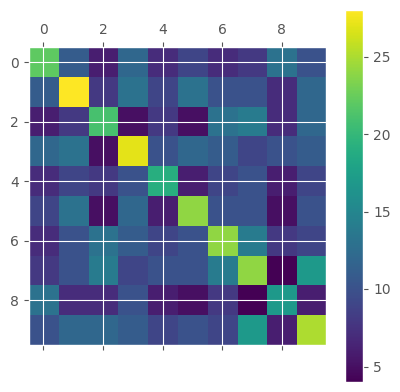

In [9]:
clf = KernelizedRegression(dna_kernel)
clf.fit(X_train, y_train)

plt.matshow(clf.K)
plt.colorbar()
plt.show()

> In order to make predictions in this classification task, we need to alter the predicted output. For that, use the `np.sign` function and evalutae your model using the `log_loss` from `sklearn.metrics`.

In [10]:
from sklearn.metrics import log_loss

y_pred = [np.sign(clf.predict(x)) for x in X_test]
loss = log_loss(y_test, y_pred)
print(loss)

2.2204460492503136e-16
